<h1 style="text-align: center;">
    Assignment 2: Image Classification
</h1>
<div style="text-align: right;"> <b>
    Name: Pronoy Patra <br>
    Roll No.: 2021112019
</div>


## Data preparation and rules


In [7]:
import torchvision
import torchvision.transforms as transforms
import numpy as np
import cv2

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(), # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,)) # Normalize the images
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

subset_indices = range(6000)
train_dataset_6k = Subset(train_dataset, subset_indices)

num_train_images = len(train_dataset)
num_test_images = len(test_dataset)

print(f"Number of training images: {num_train_images}")
print(f"Number of test images: {num_test_images}")

# Extracting X and y from the dataset
X_train = []
y_train = []
for image, label in train_dataset:
    X_train.append(image.numpy().flatten())
    y_train.append(label)

X_test = []
y_test = []
for image, label in test_dataset:
    X_test.append(image.numpy().flatten())
    y_test.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Number of training images: 60000
Number of test images: 10000
Shape of X_train: (60000, 784)
Shape of y_train: (60000,)
Shape of X_test: (10000, 784)
Shape of y_test: (10000,)


## Q1: SIFT-BoVW-SVM

### 1. Implement the SIFT detector and descriptor. Compute cluster centers for the Bag-of-Visual-Words approach. Represent the images as histograms (of visual words) and train a linear SVM model for 10-way classification.

In Bag of Words (BOW) approach:
We use image features as visual words. Key point location will be SIFT Features described by SIFT Detectors. 

Then, we count how often do such visual words appear in an image. Which is basically creating an histogram of it. 

We group several features (using clustering algorithm) together to one word, Mean feature descriptor whihch are computed from similar descriptors at the visual word. 

The visual words that results from the clustering are called the Dictinary. 

All images are now reduced to histograms. All comparisions are performed only using the histograms, not the images. 

In [55]:
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits

# Seed random numbers for reproducibility
np.random.seed(42)

# Step 1: Feature Extraction with SIFT
def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

# Step 2: Clustering to form Visual Words
def build_visual_vocabulary(descriptors, k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(descriptors)
    return kmeans.cluster_centers_

# Step 3: Encoding Images as Histograms
def encode_image_histogram(image, visual_vocabulary):
    keypoints, descriptors = extract_sift_features(image)
    histogram = np.zeros(len(visual_vocabulary))
    if descriptors is not None:
        for descriptor in descriptors:
            distances = np.linalg.norm(visual_vocabulary - descriptor, axis=1)
            closest_visual_word_index = np.argmin(distances)
            histogram[closest_visual_word_index] += 1
    return histogram

# Step 4: Training Linear SVM Model
def train_svm_model(X_train, y_train):
    svm = make_pipeline(StandardScaler(), SVC(kernel='linear'))
    svm.fit(X_train, y_train)
    return svm

# Extract SIFT descriptors from images
descriptors = []
for image in X_train:
    _, des = extract_sift_features(image.reshape((28, 28)).astype(np.uint8))
    if des is not None:
        descriptors.extend(des)

# Building visual vocabulary
k = 50  # Number of visual words
visual_vocabulary = build_visual_vocabulary(np.array(descriptors), k)

# Encode train images as histograms
X_train_histograms = []
for image in X_train:
    histogram = encode_image_histogram(image.reshape((28, 28)).astype(np.uint8), visual_vocabulary)
    X_train_histograms.append(histogram)

# Train SVM model
svm_model = train_svm_model(X_train_histograms, y_train)

# Evaluate the model
X_test_histograms = []
for image in X_test:
    histogram = encode_image_histogram(image.reshape((28, 28)).astype(np.uint8), visual_vocabulary)
    X_test_histograms.append(histogram)

y_pred = svm_model.predict(X_test_histograms)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7076


If a word occur in every image then it will not help in comparisions. So, we can use wights depending on the imformation it is going to convey. 
This is done using TF-IDF: Term Frequency Inverse Document Frequency. 

$t_{id} = \frac{f_{nid}}{n_{d}}\log\frac{N}{n_{i}}$

$t_{id}:$ histogram bin of word $i$ for image $d$

$n_{id}:$ occurences of word $i$ in image $d$

$n_d:$ number of word occurences in image $d$

$n_i:$ number of images that contain word $i$

$N:$ number of images

This method can increase its accuracy even more by focusing on the more important visual words than all the words. 


### 2. Keeping everything else constant, plot how classification accuracy changes as you sweep across 6 different values for the number of clusters. Please decide what numbers are meaningful for this question. Explain the trends in classification accuracy that you observe.

Number of Cluster = 1	Accuracy: 0.2153
Number of Cluster = 3	Accuracy: 0.2795
Number of Cluster = 10	Accuracy: 0.4588
Number of Cluster = 100	Accuracy: 0.7744
Number of Cluster = 300	Accuracy: 0.8352
Number of Cluster = 600	Accuracy: 0.8513
[0.2153, 0.2795, 0.4588, 0.7744, 0.8352, 0.8513]


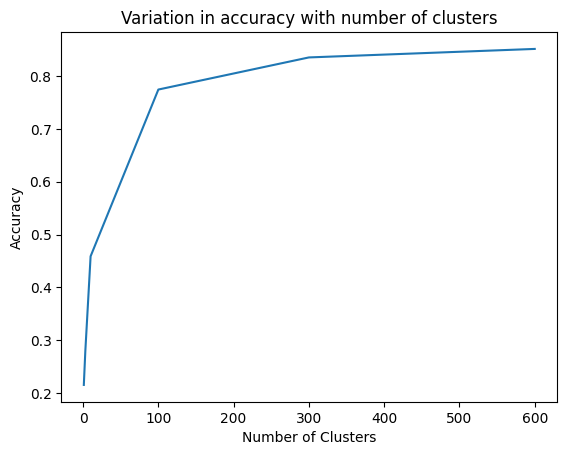

In [57]:
num_cluster = [1,3,10,100,300,600]
accuracy_cluster = []

for k in num_cluster:
    # Build visual vocabulary
    # k: Number of visual words
    print(f"Number of Cluster = {k}", end = '\t')
    visual_vocabulary = build_visual_vocabulary(np.array(descriptors), k)
    
    # Encode train images as histograms
    X_train_histograms = []
    for image in X_train:
        histogram = encode_image_histogram(image.reshape((28, 28)).astype(np.uint8), visual_vocabulary)
        X_train_histograms.append(histogram)
    
    # Train SVM model
    svm_model = train_svm_model(X_train_histograms, y_train)
    
    # Evaluate the model
    X_test_histograms = []
    for image in X_test:
        histogram = encode_image_histogram(image.reshape((28, 28)).astype(np.uint8), visual_vocabulary)
        X_test_histograms.append(histogram)
    
    y_pred = svm_model.predict(X_test_histograms)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_cluster.append(accuracy)
    print("Accuracy:", accuracy)

print(accuracy_cluster)
import matplotlib.pyplot as plt
plt.plot(num_cluster, accuracy_cluster)

# Add labels and title
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.title('Variation in accuracy with number of clusters')

# Show plot
plt.show()


**What numbers are meaningful for this question**

Only those numbers would be crucial with whom we can detect SIFT features. Otherwise, if we cannot detect any SIFT or visual features then it cannot be used for training and hence are of no use.

**Trend in the classification accuracy**

We can observe that as the number of cluster increases the accuracy increases as well. This is because more visual words are considered in BoVW. Resulting in to consideration of more visual features and hence better accuracy. 



### 3. Show the results for 6 different hyperparameter settings. You may play with the SIFT detector or descriptor and the linear SVM. Keep the number of clusters constant based on the answer to the previous question. Explain the trends in classification accuracy that you observe.

In [ ]:
c_list = [1, 0.5, 1.5]
loss_list = ['squared_hinge', 'hinge']
k = 50
accuracies = []
for c in c_list:
    for loss_function in loss_list:
        print(f"C = {c}\tLoss Function = {loss_function}", end = '\t')
        k = 50  # Number of visual words
        visual_vocabulary = build_visual_vocabulary(np.array(descriptors), k)
        
        # Encode train images as histograms
        X_train_histograms = []
        for image in X_train:
            histogram = encode_image_histogram(image.reshape((28, 28)).astype(np.uint8), visual_vocabulary)
            X_train_histograms.append(histogram)
        
        # Train SVM model
        
        svm = make_pipeline(StandardScaler(), svm.LinearSVC(dual = 'auto', C = c, loss = loss_function))
        svm.fit(X_train_histograms, y_train)
        
        # Evaluate the model
        X_test_histograms = []
        for image in X_test:
            histogram = encode_image_histogram(image.reshape((28, 28)).astype(np.uint8), visual_vocabulary)
            X_test_histograms.append(histogram)
        
        y_pred = svm_model.predict(X_test_histograms)
        accuracy = accuracy_score(y_test, y_pred)
        print("Accuracy:", accuracy)

**Trends in Classification Accuracy**

**C**

The regularization parameter (C) in SVMs controls the trade-off between maximizing the margin and minimizing the classification error. 

<u>High Regularization (Small C):</u>

When C is small, the SVM maximizes the margin and allows for a larger number of misclassifications.

Small C values lead to a simpler decision boundary, often with a larger margin between classes resulting in robust and generalized model, less prone to overfitting.

However, too much regularization (very small C values) may lead to underfitting, where the model is too simplistic and fails to capture the complexities of the data.

<u>Low Regularization (Large C):</u>

When C is large, the SVM minimizes the classification error at the expense of a smaller margin.

Large C values allow the SVM to be more flexible in fitting the training data, potentially leading to a more complex decision boundary.

A larger C value can make the SVM more sensitive to outliers and noisy data points, potentially leading to overfitting.

**Loss Function**

<u>Hinge Loss:</u>

It penalizes misclassifications by the amount by which they violate the margin.

Hinge loss encourages maximizing the margin between classes, which is desirable for digit recognition where clear class boundaries are essential.

The hinge loss is convex and leads to convex optimization problems, making it computationally efficient to solve.

<u>Squared Hinge Loss:</u>

It is a variant of the hinge loss that penalizes misclassifications more severely. It squares the margin violations, leading to a smoother optimization landscape.

Squared hinge loss can be more robust to outliers compared to hinge loss, as it penalizes large margin violations more strongly.
ameter C. test set.

## Q2: CNNs and Transformers

### 1. Set up a modular codebase for training a CNN (LeNet) on the task of handwritten digit recognition.

#### Implement logging

In [32]:
import wandb
project_name = 'logging_CNN'
group_name = 'CNN'
experiment_name = 'hyperparameters'
wandb.init(
    project=project_name,
    group=group_name,
    name=experiment_name,
    config={
        "optimizer": "Adam",
        "loss": "crossentropy",  
        "metric": "accuracy",
        "epoch": 10
    })
config = wandb.config

wandb: Currently logged in as: pronoy-patra. Use `wandb login --relogin` to force relogin


In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from sklearn.metrics import accuracy_score

# LeNet model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

# Training the model
def train_model(train_loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    return total_loss / len(train_loader)

# Evaluating the model
def evaluate_model(data_loader, model, device):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            
    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy

# Clear functional separation between the data (dataset and dataloader)
def get_data_loaders(train_dataset_para, batch_size=64):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    train_loader = DataLoader(dataset=train_dataset_para, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader

# Training and evaluation for different hyperparameter settings - Wandb loggin
def run_experiment_wandb(batch_size, learning_rate, optimizer_name, num_epochs, dataset_para, device):
    train_loader, test_loader = get_data_loaders(dataset_para, batch_size=batch_size)

    model = LeNet().to(device)
    criterion = nn.CrossEntropyLoss()
    
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

    for epoch in range(num_epochs):
        train_loss = train_model(train_loader, model, criterion, optimizer, device)
        evaluation_loss = train_model(test_loader, model, criterion, optimizer, device)

        train_accuracy = evaluate_model(train_loader, model, device)
        evaluation_accuracy = evaluate_model(test_loader, model, device)
        
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}')
        
        wandb.log({"Train loss":train_loss})
        wandb.log({"Evaluation accuracy":train_accuracy})

        wandb.log({"Evaluation loss":evaluation_loss})
        wandb.log({"Evaluation accuracy":evaluation_accuracy})

    accuracy = evaluate_model(test_loader, model, device)
    print(f'Test Accuracy: {accuracy:.4f}\n')

# No wandb login - Used for hyperparameter tuning
def run_experiment(batch_size, learning_rate, optimizer_name, num_epochs, dataset_para, device):
    train_loader, test_loader = get_data_loaders(dataset_para, batch_size=batch_size)

    model = LeNet().to(device)
    criterion = nn.CrossEntropyLoss()
    
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

    for epoch in range(num_epochs):
        train_loss = train_model(train_loader, model, criterion, optimizer, device)
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}')

    accuracy = evaluate_model(test_loader, model, device)
    print(f'Test Accuracy: {accuracy:.4f}\n')

batch_size=64
learning_rate=0.001
optimizer_name='Adam'
num_epochs = 10
print(f"Experiment: Batch Size={batch_size}, Learning Rate={learning_rate}, Optimizer={optimizer_name}")
run_experiment_wandb(batch_size, learning_rate, optimizer_name, num_epochs, train_dataset, device='cuda' if torch.cuda.is_available() else 'cpu')


Experiment: Batch Size=64, Learning Rate=0.001, Optimizer=Adam
Epoch 1/10, Training Loss: 0.2617
Epoch 2/10, Training Loss: 0.0652
Epoch 3/10, Training Loss: 0.0450
Epoch 4/10, Training Loss: 0.0350
Epoch 5/10, Training Loss: 0.0300
Epoch 6/10, Training Loss: 0.0251
Epoch 7/10, Training Loss: 0.0224
Epoch 8/10, Training Loss: 0.0181
Epoch 9/10, Training Loss: 0.0179
Epoch 10/10, Training Loss: 0.0143
Test Accuracy: 0.9955



### 2. Show the results for 6 different settings of hyperparameters. You may want to change the batch size, learning rate, and optimizer.

In [34]:
# Set hyperparameters for different experiments
# Changing batch size, learning rate, and optimizer

hyperparameter_settings = [
    (64, 0.01, 'SGD', 5),
    (128, 0.001, 'SGD', 5),
    (64, 0.001, 'Adam', 5),
    (128, 0.01, 'Adam', 5),
    (32, 0.001, 'SGD', 5),
    (32, 0.01, 'Adam', 5)
]

# Run experiments
for setting in hyperparameter_settings:
    batch_size, learning_rate, optimizer_name, num_epochs = setting
    print(f"Experiment: Batch Size={batch_size}, Learning Rate={learning_rate}, Optimizer={optimizer_name}")
    run_experiment(batch_size, learning_rate, optimizer_name, num_epochs, train_dataset, device='cuda' if torch.cuda.is_available() else 'cpu')


Experiment: Batch Size=64, Learning Rate=0.01, Optimizer=SGD
Epoch 1/5, Training Loss: 1.8765
Epoch 2/5, Training Loss: 0.3234
Epoch 3/5, Training Loss: 0.1678
Epoch 4/5, Training Loss: 0.1193
Epoch 5/5, Training Loss: 0.0951
Test Accuracy: 0.9750

Experiment: Batch Size=128, Learning Rate=0.001, Optimizer=SGD
Epoch 1/5, Training Loss: 2.3045
Epoch 2/5, Training Loss: 2.3014
Epoch 3/5, Training Loss: 2.2985
Epoch 4/5, Training Loss: 2.2954
Epoch 5/5, Training Loss: 2.2920
Test Accuracy: 0.1441

Experiment: Batch Size=64, Learning Rate=0.001, Optimizer=Adam
Epoch 1/5, Training Loss: 0.2590
Epoch 2/5, Training Loss: 0.0665
Epoch 3/5, Training Loss: 0.0492
Epoch 4/5, Training Loss: 0.0391
Epoch 5/5, Training Loss: 0.0328
Test Accuracy: 0.9868

Experiment: Batch Size=128, Learning Rate=0.01, Optimizer=Adam
Epoch 1/5, Training Loss: 0.1884
Epoch 2/5, Training Loss: 0.0757
Epoch 3/5, Training Loss: 0.0658
Epoch 4/5, Training Loss: 0.0593
Epoch 5/5, Training Loss: 0.0551
Test Accuracy: 0.9851

**Trends in classification accuracy**

As we can observe from the values that:
* <u>Learning Rate:</u> Low learning rate gives better accuracies, but too less learning rates can lead to slower convergence.
* <u>Optimizer:</u> We observe that Adam optimizer is better than SGD in all the cases, becauses it utlises the concepts of adaptive learning rate and momentum.
* <u>Batch Size:</u> We observe that the more the batch size, the model reaches convergence earlier as they lead to training stability, i.e., smoother gradient estimation by averaging gradients over more samples.

**Which hyperparameters are most important?**

Apart from Learning Rate, batch size, number of epochs and optimizers, there are multiple other hyperparameters that are crucial while training a CNN. 
* <u>Network architecture:</u> This includes number of layers, the size of the layers, the type of layers (e.g., convolutional, pooling, fully connected), and the connectivity between layers. 
* <u>Activation Function:</u> The choice of activation function can affect the model's training speed and performance. Like ReLU (Rectified Linear Unit), tanh, and sigmoid. 


### 3. Compare the best performing CNN (from above) against the SIFT-BoVW-SVM approach.

As we can observe from above that CNN (Accuracy more than 95%) are much better than SIFT-BoVW-SVM approach (Accuracy around 70%).
Major reasons behind this are: 

* <u>Feature Learning:</u>

**CNNs:** CNNs extract hierarchical features from images during training leading to better performance.

**SIFT-BoVW-SVM:** It relies on SIFT and BoVW for feature representation and might not capture all the relevant information in complex datasets, limiting the approach's performance.

* <u>Performance:</u>

**CNNs:** They can learn complex patterns and hierarchical representations directly from data, leading to high accuracy.

**SIFT-BoVW-SVM:** The performance is limited and can give bad accuracies for datasets containing significant variability or large-scale variations.
tions.


### 4. How does the performance change if you double the number of convolutional layers?

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define the LeNet model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.conv4 = nn.Conv2d(120, 84, kernel_size=1)
        self.fc1 = nn.Linear(84 * 1 * 1, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = x.view(-1, 84 * 1 * 1)
        x = self.fc1(x)
        return x


# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()          

# Testing
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 98 %


Adding more convolutional layers increases the capacity of the network to extract hierarchical features from the input data improving the model's ability to learn complex patterns and representations, leading to better performance. 

But the number of parameters have increased leading to more number of parameters and hence more time and space complexity. 

### 5. How does the performance change as you increase the number of training samples

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from sklearn.metrics import accuracy_score

# LeNet model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

# Training the model
def train_model(train_loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    return total_loss / len(train_loader)

# Evaluating the model
def evaluate_model(data_loader, model, device):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            
    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy

# Clear functional separation between the data (dataset and dataloader)
def get_data_loaders(train_dataset_para, batch_size=64):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    train_loader = DataLoader(dataset=train_dataset_para, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader

def run_experiment(batch_size, learning_rate, optimizer_name, num_epochs, dataset_para, device):
    train_loader, test_loader = get_data_loaders(dataset_para, batch_size=batch_size)

    model = LeNet().to(device)
    criterion = nn.CrossEntropyLoss()
    
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

    for epoch in range(num_epochs):
        train_loss = train_model(train_loader, model, criterion, optimizer, device)
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}')

    accuracy = evaluate_model(test_loader, model, device)
    print(f'Test Accuracy: {accuracy:.4f}\n')


batch_size=64
learning_rate=0.001
optimizer_name='Adam'
num_epochs = 5
print(f"Experiment: Batch Size={batch_size}, Learning Rate={learning_rate}, Optimizer={optimizer_name}")

samples =  [600, 1800, 6000, 18000, 60000]
for s in samples: 
    # Select a subset of 6000 images
    subset_indices = range(s)
    train_dataset_samples = Subset(train_dataset, subset_indices)
    print(f"Training Samples: {s}")
    run_experiment(batch_size, learning_rate, optimizer_name, num_epochs, train_dataset_samples, device='cuda' if torch.cuda.is_available() else 'cpu')
    print('\n')


Experiment: Batch Size=64, Learning Rate=0.001, Optimizer=Adam
Training Samples: 600
Epoch 1/5, Training Loss: 2.2903
Epoch 2/5, Training Loss: 2.1951
Epoch 3/5, Training Loss: 1.9328
Epoch 4/5, Training Loss: 1.4190
Epoch 5/5, Training Loss: 0.9353
Test Accuracy: 0.7468



Training Samples: 1800
Epoch 1/5, Training Loss: 2.0885
Epoch 2/5, Training Loss: 1.0325
Epoch 3/5, Training Loss: 0.5556
Epoch 4/5, Training Loss: 0.3758
Epoch 5/5, Training Loss: 0.3100
Test Accuracy: 0.9128



Training Samples: 6000
Epoch 1/5, Training Loss: 1.1428
Epoch 2/5, Training Loss: 0.3049
Epoch 3/5, Training Loss: 0.1936
Epoch 4/5, Training Loss: 0.1434
Epoch 5/5, Training Loss: 0.1120
Test Accuracy: 0.9611



Training Samples: 18000
Epoch 1/5, Training Loss: 0.6072
Epoch 2/5, Training Loss: 0.1578
Epoch 3/5, Training Loss: 0.1030
Epoch 4/5, Training Loss: 0.0820
Epoch 5/5, Training Loss: 0.0649
Test Accuracy: 0.9778



Training Samples: 60000
Epoch 1/5, Training Loss: 0.2640
Epoch 2/5, Training Loss: 0.

**Explain the trends in classification accuracy**

We can observe that as the training samples increases, the accuracy of the model increases. THis is because as the sample size increases the CNN tends to learn better and hence can learn the features more effectively. 


### 6. 2 layer TransformerEncoder.

#### ViT style prediction scheme, evaluate classification accuracy when training with 60K - Positional Encoding: Sinusoids

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import math

# Define positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Define the model
class ViT(nn.Module):
    def __init__(self, patch_size=7, hidden_dim=64, num_classes=10, num_layers=2, num_heads=4, dropout=0.1):
        super(ViT, self).__init__()
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.num_layers = num_layers

        # Linear projection for patches
        self.linear_projection = nn.Linear(patch_size * patch_size, hidden_dim)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(hidden_dim, dropout)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classifier head
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Convert the 28x28 images to 7x7 patches
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(x.size(0), x.size(2) * x.size(3), -1)
        
        # Linear projection for patches
        x = self.linear_projection(x)
        
        # Add positional encoding
        x = self.positional_encoding(x)

        # Transformer Encoder
        x = self.transformer_encoder(x)

        # Classifier head
        x = x.mean(1)  # Global average pooling
        x = self.fc(x)
        return x

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}")

# Evaluation
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy on test set: {accuracy:.4f}")


C:\Users\BPATR\OneDrive\Desktop\cv\cvenv\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/5], Loss: 1.0374
Epoch [2/5], Loss: 0.2592
Epoch [3/5], Loss: 0.1745
Epoch [4/5], Loss: 0.1372
Epoch [5/5], Loss: 0.1214
Accuracy on test set: 0.9688


#### ViT style prediction scheme, evaluate classification accuracy when training with 6K - Postional Encoding: Sinusoids

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import math

# Define positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Define the model
class ViT(nn.Module):
    def __init__(self, patch_size=7, hidden_dim=64, num_classes=10, num_layers=2, num_heads=4, dropout=0.1):
        super(ViT, self).__init__()
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.num_layers = num_layers

        # Linear projection for patches
        self.linear_projection = nn.Linear(patch_size * patch_size, hidden_dim)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(hidden_dim, dropout)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classifier head
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Convert the 28x28 images to 7x7 patches
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(x.size(0), x.size(2) * x.size(3), -1)
        
        # Linear projection for patches
        x = self.linear_projection(x)
        
        # Add positional encoding
        x = self.positional_encoding(x)

        # Transformer Encoder
        x = self.transformer_encoder(x)

        # Classifier head
        x = x.mean(1)  # Global average pooling
        x = self.fc(x)
        return x

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset_6k, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}")

# Evaluation
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy on test set: {accuracy:.4f}")


C:\Users\BPATR\OneDrive\Desktop\cv\cvenv\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/5], Loss: 2.2322
Epoch [2/5], Loss: 1.7926
Epoch [3/5], Loss: 1.3977
Epoch [4/5], Loss: 1.0848
Epoch [5/5], Loss: 0.8184
Accuracy on test set: 0.8087


#### ViT style prediction scheme, evaluate classification accuracy when training with 60K - Postional Encoding: Random Numbers

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import numpy as np

# Define the model
class ViT(nn.Module):
    def __init__(self, patch_size=7, hidden_dim=64, num_classes=10, num_layers=2, num_heads=4, dropout=0.1):
        super(ViT, self).__init__()
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.num_layers = num_layers

        # Linear projection for patches
        self.linear_projection = nn.Linear(patch_size * patch_size, hidden_dim)

        # Random positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, hidden_dim))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classifier head
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Convert the 28x28 images to 7x7 patches
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(x.size(0), x.size(2) * x.size(3), -1)
        
        # Linear projection for patches
        x = self.linear_projection(x)
        
        # Add positional encoding
        x = x + self.positional_encoding

        # Transformer Encoder
        x = self.transformer_encoder(x)

        # Classifier head
        x = x.mean(1)  # Global average pooling
        x = self.fc(x)
        return x

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}")

# Evaluation
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy on test set: {accuracy:.4f}")


C:\Users\BPATR\OneDrive\Desktop\cv\cvenv\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/5], Loss: 0.8282
Epoch [2/5], Loss: 0.1983
Epoch [3/5], Loss: 0.1369
Epoch [4/5], Loss: 0.1119
Epoch [5/5], Loss: 0.0965
Accuracy on test set: 0.9681


#### ViT style prediction scheme, evaluate classification accuracy when training with 6K - Postional Encoding: Random Numbers

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import numpy as np

# Define the model
class ViT(nn.Module):
    def __init__(self, patch_size=7, hidden_dim=64, num_classes=10, num_layers=2, num_heads=4, dropout=0.1):
        super(ViT, self).__init__()
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.num_layers = num_layers

        # Linear projection for patches
        self.linear_projection = nn.Linear(patch_size * patch_size, hidden_dim)

        # Random positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, hidden_dim))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classifier head
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Convert the 28x28 images to 7x7 patches
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(x.size(0), x.size(2) * x.size(3), -1)
        
        # Linear projection for patches
        x = self.linear_projection(x)
        
        # Add positional encoding
        x = x + self.positional_encoding

        # Transformer Encoder
        x = self.transformer_encoder(x)

        # Classifier head
        x = x.mean(1)  # Global average pooling
        x = self.fc(x)
        return x

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset_6k, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}")

# Evaluation
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy on test set: {accuracy:.4f}")


C:\Users\BPATR\OneDrive\Desktop\cv\cvenv\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/5], Loss: 2.1691
Epoch [2/5], Loss: 1.6331
Epoch [3/5], Loss: 1.1398
Epoch [4/5], Loss: 0.7950
Epoch [5/5], Loss: 0.5723
Accuracy on test set: 0.8810


We can observe that training with 60k dataset always outperforms 6k dataset. As more data leads to better training of the model and hence better accuracies. 

**How do the results compare against CNNs?**

In CNN we observe lesser accuracy compared to ViT.?